In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15475562531438750000
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3196895232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2012501955250745380
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
import keras
import tensorflow as tf


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.manifold import TSNE
import shap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean, cosine
import umap
import random
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, homogeneity_score
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
df = pd.read_csv('../datasets/yelp_dataset.csv')
df.head()

,Unnamed: 0,text,label,processed
0,0,wow loved this place,1,love place
1,1,crust is not good,0,crust good
2,2,not tasty and the texture was just nasty,0,tasty texture just nasty
3,3,stopped by during the late may bank holiday of...,1,stop during late bank holiday recommendation love
4,4,the selection on the menu was great and so wer...,1,selection menu great price


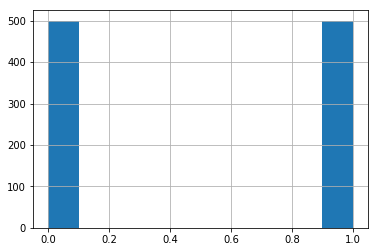

In [6]:
df['label'].hist()

In [7]:
df.dropna(inplace=True)

In [8]:
x = df['processed'].values
y = df['label'].values


## TF-IDF
We are going to use TF*IDF (Term frequency- Inverse document frequency) vectorizer to convert our text into numbers.
TF = Frequency of term
IDF = No of docs/ No of docs with the term

In [24]:
tfid = TfidfVectorizer(max_features=5000)
x1 = tfid.fit_transform(x).toarray()
x1.shape

(997, 1441)

In [26]:
tfid.get_feature_names();

#### Splitting data
We split data as follows:
- train = 20%
- test = 20%
- unlabelled pool = 60% (this is the data which we want the domain expert to label)

In [ ]:
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.5*x.shape[0])]
test_indices = indices[round(0.5*x.shape[0]): round(0.7*x.shape[0])]
pool_indices = indices[round(0.7*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[test_indices]['text'].values
df_pool = df.iloc[pool_indices]['text'].values
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]
x_pool = x[pool_indices]
y_pool = y[pool_indices]

#### Model fitting
We are going to use Logistic regression with L1 regularization. Reasons for L1:
- We are going to apply shapely values - L1 => sparse model => better for interpretability
- We prefer a sparse model because not all features are important (feature selection)
- It results in better accuracy in this case

In [ ]:
PENALTY = 'l2'
C = 2
max_iter = 2000

In [ ]:
model = LogisticRegression(penalty=PENALTY, C=C, max_iter=max_iter)
model.fit(x_train, y_train)
model.score(x_train,y_train)

We measure the f1_score and plot confusion matrix. Recall:
- f1 score = 2PR/ (P+R)
- P = actual pos/ predicted pos
- R = predicted pos/ total actual pos

In [ ]:
predictions = model.predict(x_test)
f1_score(predictions,
         y_test)

In [ ]:
accuracy_score(y_test, predictions)

In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions),annot=True)

In [ ]:
np.array(np.unique(y_test, return_counts=True)).T

# LSTM

In [9]:
y = df['label'].values

In [10]:
indices =  np.random.randint(low=0, high=x.shape[0], size=x.shape[0])
train_indices = indices[0:round(0.5*x.shape[0])]
pool_indices = indices[round(0.5*x.shape[0]):]
df_train = df.iloc[train_indices]['text'].values
df_test = df.iloc[pool_indices]['text'].values
y_train = y[train_indices]
y_test = y[pool_indices]

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train)

X_train = tokenizer.texts_to_sequences(df_train)
X_test = tokenizer.texts_to_sequences(df_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(df_train[2])
print(X_train[2])

my fianc  and i came in the middle of the day and we were greeted and seated right away 
[27, 623, 2, 3, 70, 13, 1, 624, 12, 1, 394, 2, 17, 24, 625, 2, 626, 140, 155]


In [12]:
max_features = vocab_size
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 16

print('Loading data...')
(x_train, y_train), (x_test, y_test) = (X_train, y_train), (X_test, y_test)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
498 train sequences
499 test sequences
Pad sequences (samples x time)
x_train shape: (498, 80)
x_test shape: (499, 80)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 498 samples, validate on 499 samples
Epoch 1/10
498/498 [==============================] - 8s 15ms/step - loss: 0.6842 - acc: 0.5422 - val_loss: 0.6711 - val_acc: 0.5792
Epoch 2/10
498/498 [==============================] - 5s 11ms/step - loss: 0.5895 - acc: 0.7731 - val_loss: 0.8642 - val_acc: 0.5691
Epoch 3/10
498/498 [==============================] - 5s 11ms/step - loss: 0.3353 - acc: 0.8936 - val_loss: 0.4378 - val_acc: 0.7956
Epoch 4/10
498/498 [==============================] - 5s 10ms/step - loss: 0.1361 - acc: 0.9558 - val_loss: 0.3979 - val_acc: 0.8216
Epoch 5/10
498/498 [========

In [13]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:100])

Instructions for updating:
Use tf.cast instead.


In [14]:
# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

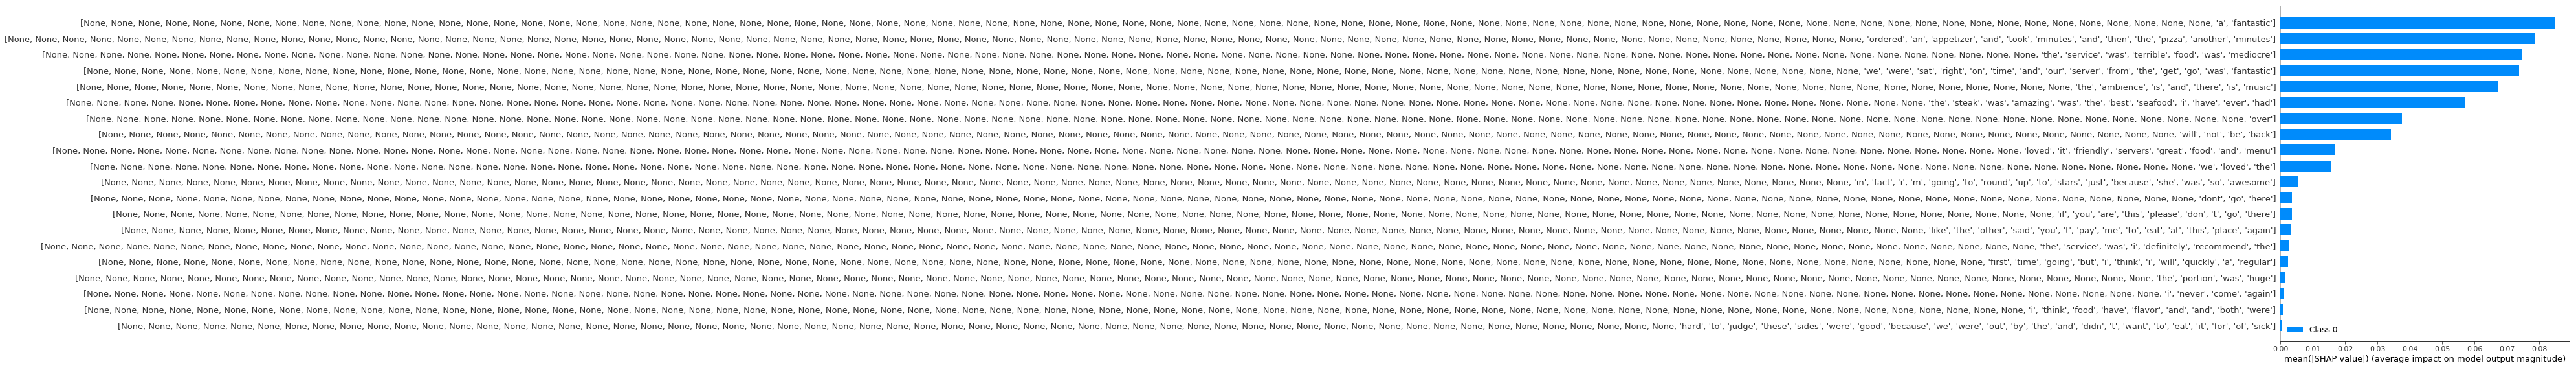

In [23]:
shap.summary_plot(shap_values, x_test[:100], my_texts)

In [16]:
x_test

array([[   0,    0,    0, ...,    8,   19,   88],
       [   0,    0,    0, ...,    0,  166,  239],
       [   0,    0,    0, ...,    5,    1,  572],
       ...,
       [   0,    0,    0, ...,   21, 1021, 1022],
       [   0,    0,    0, ...,  143,   23,  672],
       [   0,    0,    0, ...,  175,   16,  102]])

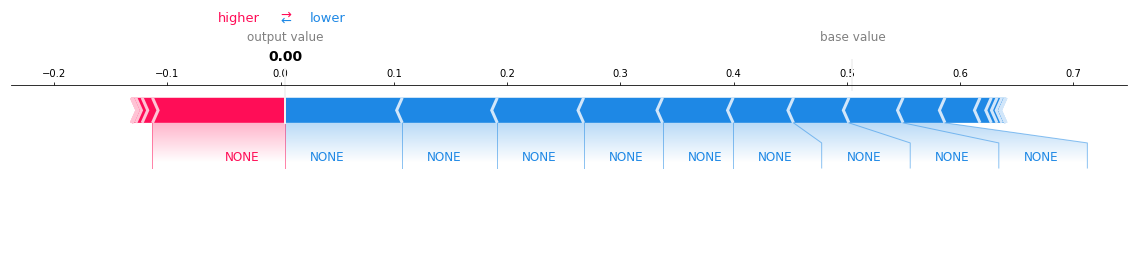

(None, <shap.plots.force.AdditiveExplanation at 0x2130f75c940>)

In [17]:
# transform the indexes to words
import numpy as np
words = reverse_word_map
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0], matplotlib=True)

#### SHAP Linear explainer

Refer https://christophm.github.io/interpretable-ml-book/shap.html

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features

We call the SHAP explainer for linear models
shapely values produced have same dimensions as data passed

In [ ]:
explainer = shap.LinearExplainer(model, x_train,feature_dependence="independent")
shap_values_train = explainer.shap_values(x_train)
shap_values_pool = explainer.shap_values(x_pool)

In [ ]:
shap.summary_plot(shap_values_pool, x_pool, feature_names=tfid.get_feature_names())

In [ ]:
shap_values_pool.shape

#### Clustering data
We are going to cluster the training data 
    - using shapely values (shapely space)
SHAP clustering works by clustering on Shapley values of each instance. 
This means that you cluster instances by explanation similarity

In [ ]:
pca = PCA(n_components=2)
principals_pca = pca.fit_transform(shap_values_pool)

In [ ]:
u = umap.UMAP(n_components=2, random_state=100,  metric='euclidean', n_neighbors=100, min_dist=1)
principals_umap = u.fit_transform(shap_values_pool)

In [ ]:
tsne = TSNE(n_components=2, perplexity=20)
principals = tsne.fit_transform(
    shap_values_pool)

In [ ]:
n_clusters = 20

In [ ]:
kmeans = KMeans(n_clusters= n_clusters, n_jobs=-1, max_iter=600)
kmeans.fit(shap_values_pool)


In [ ]:
print("Homogenity score", homogeneity_score(y_pool, kmeans.labels_))

We use cosine distance instead of euclidean distance to measure the similarity between the documents.
As the size of the document increases, the number of common words (euclidean) tend to increase 
even if the documents talk about different topics. The cosine similarity helps overcome this fundamental flaw 
and finds the similarity irrespective of size.

https://www.machinelearningplus.com/nlp/cosine-similarity/

In [ ]:
# Find similarity of each point in cluster to its centroid
similarity_to_center = []
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i] # cluster of this instance
    centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
    similarity = 1-cosine(instance, centroid) # 1- cosine distance gives similarity
    similarity_to_center.append(similarity)

In [ ]:
centroid_match = [None]*n_clusters
centroid_indices =[None]*n_clusters
for i, instance in enumerate(shap_values_pool):
    cluster_label = kmeans.labels_[i]     
    if centroid_match[cluster_label] is None or similarity_to_center[i] > centroid_match[cluster_label]:
        centroid_indices[cluster_label] = i
        centroid_match[cluster_label] = similarity_to_center[i]
        

In [ ]:
data = []
collect = dict()
color = ['hsl(' + str(h) + ',80%' + ',50%)' for h in np.linspace(0, 255, n_clusters)]
# color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(n_clusters)]
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    cluster_text = df_pool[cluster_indices]
    center_index = centroid_indices[cluster_id]

    cp = principals[cluster_indices]
    data.append(go.Scatter(x = cp[:,0],
                   y = cp[:,1],
                   mode='markers',                    
                hovertext=cluster_text,
                           text = cluster_text,
                           textposition = 'middle right',
                            marker=dict(color=color[cluster_id],
                                                   size=10),
                           name = 'cluster '+ str(cluster_id)
                          ))
    data.append(go.Scatter(x = [principals[center_index, 0]],
                   y = [principals[center_index, 1]],
                           visible=True,
                   mode='markers',  
                           marker=dict(color=color[cluster_id],
                                                   size=15,
                                                   line=dict(color='black', width=5)),
                           name = 'centroid cluster '+ str(cluster_id)
                          ))
    collect[cluster_id] = df_pool[cluster_indices]
    
fig = go.Figure(data=data)
fig.show()
#plotly.offline.plot(fig)

In [ ]:
#url=py.plot(fig, filename='bird', sharing='public')

In [ ]:
centroid_indices

In [ ]:
# for item in collect[11]:
#     print(item)

#### Propagate label of centroid to entire cluster

In [ ]:
y_pool_new = np.zeros(shape=y_pool.shape)
for cluster_id in np.unique(kmeans.labels_):
    cluster_indices = np.where(kmeans.labels_ == cluster_id)    
    center_index = centroid_indices[cluster_id]
    center_label = y_pool[center_index]
    print(center_label)
    y_pool_new[cluster_indices] = center_label
    print(y_pool_new[cluster_indices])
y_new = np.zeros(shape=y.shape)
y_new[pool_indices] = y_pool_new

In [ ]:
compare = (y_pool_new == y_pool)
np.where(compare==True)[0].shape

In [ ]:
compare = (y_pool_new != y_pool)
np.where(compare==True)[0].shape

In [ ]:
train_indices_new = np.append(pool_indices, centroid_indices)


In [ ]:
model1 = LogisticRegression(penalty=PENALTY, C=C, max_iter=max_iter)
x_train_new = x[train_indices_new]
y_train_new = y[train_indices_new]
model1.fit(x_train_new, y_train_new)

In [ ]:
model1.score(x_train_new, y_train_new), model1.score(x_test, y_test)

In [ ]:
predictions1 = model1.predict(x_test)
f1_score(y_test, predictions1)

In [ ]:
accuracy_score(y_test, predictions1)

#### Add entire x_pool back to training instead of just centroids

In [ ]:
train_indices_full = np.append(train_indices, pool_indices)

In [ ]:
model2 = LogisticRegression(penalty=PENALTY, C=C, max_iter=max_iter)
x_train_full = x[train_indices_full]
y_train_full = y[train_indices_full]
model2.fit(x_train_full, y_train_full)
model2.score(x_train_full, y_train_full), model2.score(x_test, y_test)

In [ ]:
predictions2 = model2.predict(x_test)
f1_score(y_test, predictions2)

In [ ]:
accuracy_score(y_test, predictions2)

#### Compare

In [ ]:
print("Model with 20% train ", f1_score(y_test, predictions))
print("Model with 20% train + propagate center ", f1_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", f1_score(y_test, predictions2))

In [ ]:
print("Model with 20% train ", accuracy_score(y_test, predictions))
print("Model with 20% train + propagate center ", accuracy_score(y_test, predictions1))
print("Model with 20% train + 60% pool ", accuracy_score(y_test, predictions2))